In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle/

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Displayting the datasets.
! kaggle datasets list

ref                                                        title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                      Spotify and Youtube                              9MB  2023-03-20 15:43:25           5159        193  1.0              
erdemtaha/cancer-data                                      Cancer Data                                     49KB  2023-03-22 07:57:00           1081         31  1.0              
ulrikthygepedersen/fastfood-nutrition                      Fastfood Nutrition                              12KB  2023-03-21 10:02:41           1336         34  1.0              
lokeshparab/amazon-products-dataset                        Amazon Products Sales Dataset 2023              80M

In [5]:
! kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:21<00:00, 41.0MB/s]
100% 812M/812M [00:21<00:00, 38.8MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

## 1. Consider the analogy of cats and dogs.

## Initial sample sizes for training, validation, and testing should be 1000, 500, and 500 respectively.

The test, validation, and training sets are being expanded with photos.

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

Utilizing the convulational neural network.

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [11]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Regularization strategies are utilized during the DATA PREPROCESSING stage since it has been demonstrated that the model may overfit.

Each picture in this case is converted into a tensor.

In [12]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


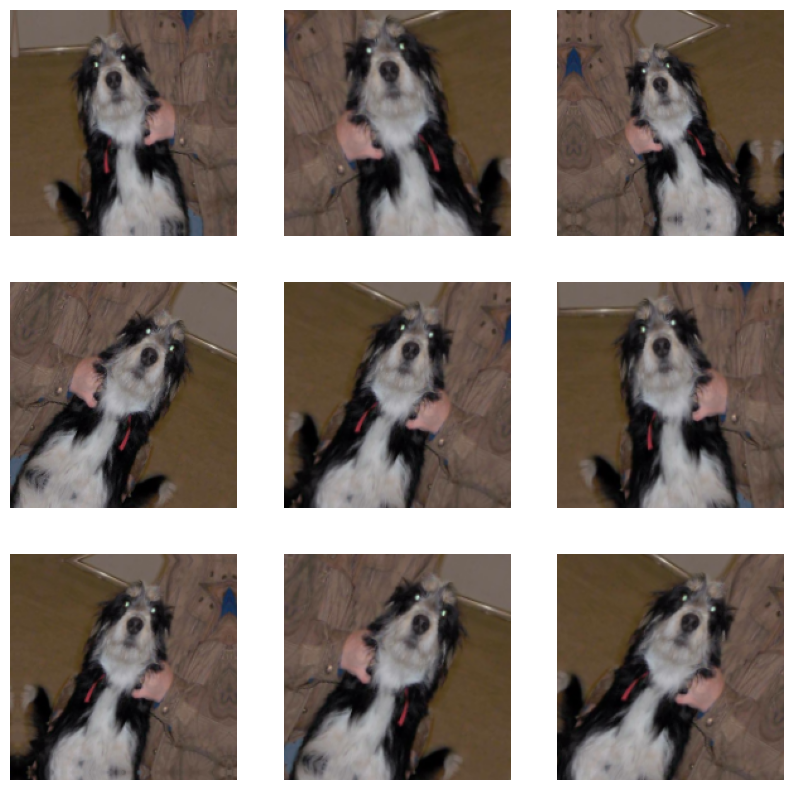

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),])
# Printing enhanced versions of a randomly selected input images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

If the model is not improving, callback can be used to stop training early or to save the model's weights after each epoch. Callbacks may also be used to log metrics, display model performance, and schedule learning rate modifications.

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 18s 99ms/step - loss: 0.6954 - accuracy: 0.5005 - val_loss: 0.7249 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 4s 66ms/step - loss: 0.6943 - accuracy: 0.5195 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 3/10
63/63 [==============================] - 5s 81ms/step - loss: 0.6838 - accuracy: 0.5670 - val_loss: 0.6870 - val_accuracy: 0.5130
Epoch 4/10
63/63 [==============================] - 4s 65ms/step - loss: 0.6745 - accuracy: 0.6260 - val_loss: 0.6282 - val_accuracy: 0.6630
Epoch 5/10
63/63 [==============================] - 4s 64ms/step - loss: 0.6352 - accuracy: 0.6440 - val_loss: 0.5898 - val_accuracy: 0.6800
Epoch 6/10
63/63 [==============================] - 6s 85ms/step - loss: 0.5844 - accuracy: 0.6870 - val_loss: 0.6329 - val_accuracy: 0.6570
Epoch 7/10
63/63 [==============================] - 4s 65ms/step - loss: 0.5787 - accuracy: 0.6915 - val_loss: 0.6070 - val_accuracy: 0.6620
Epoch 8/10
6

It is evident that accuracy grows with the number of epochs.

Accuracy= 79.05%
Val_acc= 71.20%

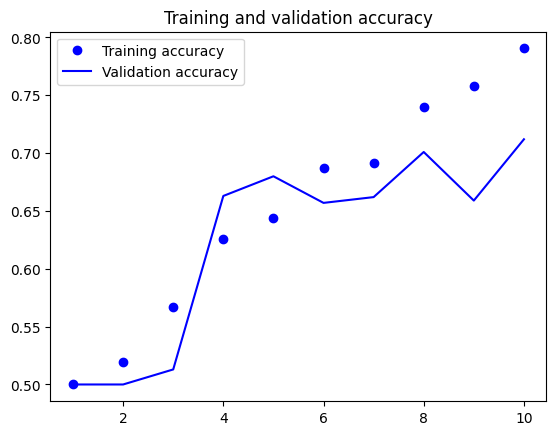

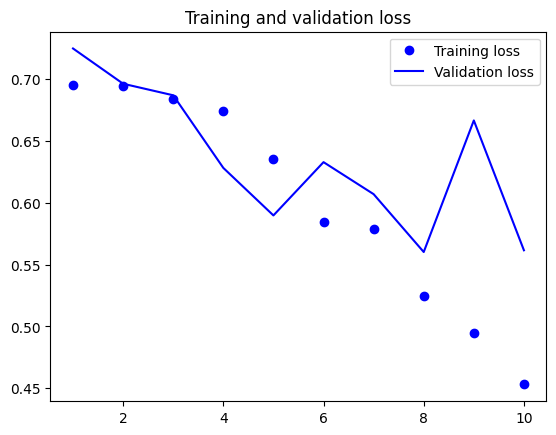

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [16]:
test_model = keras.models.load_model("convnet_from_scratch1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 34ms/step - loss: 0.5870 - accuracy: 0.6850
Test accuracy: 0.685


Test accuracy with no data augmentation = 68.5%

#Data Augmentation

The "data augmentation" method enables one to increase the size of a training set by creating new, modified versions of the original data. This lessens overfitting and improves the generalizability of the model.

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [18]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [19]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 7s 70ms/step - loss: 0.6979 - accuracy: 0.4915 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 5s 68ms/step - loss: 0.6933 - accuracy: 0.5170 - val_loss: 0.7174 - val_accuracy: 0.5000
Epoch 3/10
63/63 [==============================] - 6s 90ms/step - loss: 0.6919 - accuracy: 0.5315 - val_loss: 0.6874 - val_accuracy: 0.5610
Epoch 4/10
63/63 [==============================] - 5s 68ms/step - loss: 0.6795 - accuracy: 0.5725 - val_loss: 0.6709 - val_accuracy: 0.5970
Epoch 5/10
63/63 [==============================] - 6s 84ms/step - loss: 0.6562 - accuracy: 0.6145 - val_loss: 0.6932 - val_accuracy: 0.5610
Epoch 6/10
63/63 [==============================] - 7s 105ms/step - loss: 0.6459 - accuracy: 0.6345 - val_loss: 0.6681 - val_accuracy: 0.6030
Epoch 7/10
63/63 [==============================] - 7s 97ms/step - loss: 0.6359 - accuracy: 0.6405 - val_loss: 0.7198 - val_accuracy: 0.5810
Epoch 8/10
6

Although the model's usage of data augmentation did not result in any better results, this might still be established by increasing the size of the training sample and doing data augmentation tests on it.

Accuracy= 69.05%
Val_acc= 68.80%


In [20]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 33ms/step - loss: 0.5971 - accuracy: 0.6770
Test accuracy: 0.677


test accuracy was not improved

# 2. Increase the size of the training sample.

The training sample was expanded from 1000 to 1500 participants.

In [21]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [22]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [23]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 11s 83ms/step - loss: 0.6997 - accuracy: 0.5133 - val_loss: 0.6881 - val_accuracy: 0.6540
Epoch 2/10
94/94 [==============================] - 7s 74ms/step - loss: 0.6751 - accuracy: 0.5870 - val_loss: 0.6573 - val_accuracy: 0.6280
Epoch 3/10
94/94 [==============================] - 6s 59ms/step - loss: 0.6436 - accuracy: 0.6440 - val_loss: 0.6304 - val_accuracy: 0.6380
Epoch 4/10
94/94 [==============================] - 7s 74ms/step - loss: 0.6090 - accuracy: 0.6940 - val_loss: 0.5899 - val_accuracy: 0.6900
Epoch 5/10
94/94 [==============================] - 7s 75ms/step - loss: 0.5494 - accuracy: 0.7230 - val_loss: 0.5727 - val_accuracy: 0.6910
Epoch 6/10
94/94 [==============================] - 7s 70ms/step - loss: 0.4986 - accuracy: 0.7577 - val_loss: 0.5633 - val_accuracy: 0.7170
Epoch 7/10
94/94 [==============================] - 6s 63ms/step - loss: 0.4556 - accuracy: 0.7820 - val_loss: 0.7649 - val_accuracy: 0.6730
Epoch 8/10
9

In [25]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 35ms/step - loss: 0.5243 - accuracy: 0.7500
Test accuracy: 0.750


Accuracy= 87.17%
val_acc= 72.20%

## Applying the Data Augmentation.

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 11s 75ms/step - loss: 0.6954 - accuracy: 0.5063 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/10
94/94 [==============================] - 6s 62ms/step - loss: 0.6919 - accuracy: 0.5257 - val_loss: 0.6902 - val_accuracy: 0.5010
Epoch 3/10
94/94 [==============================] - 9s 89ms/step - loss: 0.6853 - accuracy: 0.5640 - val_loss: 0.6855 - val_accuracy: 0.5370
Epoch 4/10
94/94 [==============================] - 9s 95ms/step - loss: 0.6720 - accuracy: 0.5903 - val_loss: 0.6707 - val_accuracy: 0.5980
Epoch 5/10
94/94 [==============================] - 7s 71ms/step - loss: 0.6492 - accuracy: 0.6310 - val_loss: 0.6666 - val_accuracy: 0.5920
Epoch 6/10
94/94 [==============================] - 6s 62ms/step - loss: 0.6393 - accuracy: 0.6427 - val_loss: 0.6422 - val_accuracy: 0.6330
Epoch 7/10
94/94 [==============================] - 7s 74ms/step - loss: 0.6175 - accuracy: 0.6650 - val_loss: 0.6292 - val_accuracy: 0.6420
Epoch 8/10
9

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 33ms/step - loss: 0.5801 - accuracy: 0.7050
Test accuracy: 0.705


Accuracy= 71.97%
val_acc= 67.20%


# 3.choosing the right sample size for training.

The proper sizes for the training, validation, and test sets were 1500, 1000, and 500 respectively.

In [30]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [31]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 3000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [32]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
     

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 14s 102ms/step - loss: 0.7002 - accuracy: 0.5317 - val_loss: 0.6838 - val_accuracy: 0.5260
Epoch 2/10
94/94 [==============================] - 9s 94ms/step - loss: 0.6816 - accuracy: 0.5690 - val_loss: 0.6528 - val_accuracy: 0.6700
Epoch 3/10
94/94 [==============================] - 7s 71ms/step - loss: 0.6429 - accuracy: 0.6397 - val_loss: 0.6208 - val_accuracy: 0.6590
Epoch 4/10
94/94 [==============================] - 7s 71ms/step - loss: 0.6069 - accuracy: 0.6643 - val_loss: 0.5993 - val_accuracy: 0.6790
Epoch 5/10
94/94 [==============================] - 8s 75ms/step - loss: 0.5671 - accuracy: 0.7023 - val_loss: 0.5950 - val_accuracy: 0.6830
Epoch 6/10
94/94 [==============================] - 8s 82ms/step - loss: 0.5316 - accuracy: 0.7313 - val_loss: 0.6616 - val_accuracy: 0.6965
Epoch 7/10
94/94 [==============================] - 7s 70ms/step - loss: 0.5065 - accuracy: 0.7503 - val_loss: 0.7025 - val_accuracy: 0.6875
Epoch 8/10


In [34]:

test_model = keras.models.load_model(
    "convnet_from_scratch3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 33ms/step - loss: 0.5867 - accuracy: 0.7120
Test accuracy: 0.712


Accuracy= 84.70%
val_Acc= 68.80%


## Using the Data Augmentation.

In [35]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [36]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [37]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
94/94 [==============================] - 13s 103ms/step - loss: 0.6929 - accuracy: 0.5213 - val_loss: 0.6917 - val_accuracy: 0.5190
Epoch 2/10
94/94 [==============================] - 13s 134ms/step - loss: 0.6844 - accuracy: 0.5407 - val_loss: 0.6949 - val_accuracy: 0.5120
Epoch 3/10
94/94 [==============================] - 8s 78ms/step - loss: 0.6948 - accuracy: 0.5103 - val_loss: 0.6858 - val_accuracy: 0.5125
Epoch 4/10
94/94 [==============================] - 8s 87ms/step - loss: 0.6923 - accuracy: 0.5257 - val_loss: 0.6867 - val_accuracy: 0.5110
Epoch 5/10
94/94 [==============================] - 8s 85ms/step - loss: 0.6845 - accuracy: 0.5563 - val_loss: 0.6539 - val_accuracy: 0.6250
Epoch 6/10
94/94 [==============================] - 7s 74ms/step - loss: 0.6475 - accuracy: 0.6223 - val_loss: 0.6453 - val_accuracy: 0.6280
Epoch 7/10
94/94 [==============================] - 7s 74ms/step - loss: 0.6419 - accuracy: 0.6307 - val_loss: 0.6129 - val_accuracy: 0.6675
Epoch 8/1

In [38]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")



32/32 [==============================] - 1s 32ms/step - loss: 0.5934 - accuracy: 0.6910
Test accuracy: 0.691


Accuracy= 69.07%
val_acc= 71.65%

#4. Using a Pre-trained network.

VGG16 is the architecture of this pre-trained network.

Feature extraction - Instantiating the VGG16 convolutional base

In [39]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

Extracting features and their accompanying labels is known as feature extraction.

In [40]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

train_features.shape

1/1 [==============================] - 1s 1s/step


(3000, 5, 5, 512)

Feature extraction - Defining and training the densely connected classifier.

In [41]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extractionPT1.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=15,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/15
94/94 [==============================] - 2s 11ms/step - loss: 12.9946 - accuracy: 0.9333 - val_loss: 7.3212 - val_accuracy: 0.9585
Epoch 2/15
94/94 [==============================] - 1s 7ms/step - loss: 3.5448 - accuracy: 0.9730 - val_loss: 4.9409 - val_accuracy: 0.9700
Epoch 3/15
94/94 [==============================] - 1s 8ms/step - loss: 1.3773 - accuracy: 0.9890 - val_loss: 7.0744 - val_accuracy: 0.9665
Epoch 4/15
94/94 [==============================] - 1s 8ms/step - loss: 0.8807 - accuracy: 0.9920 - val_loss: 5.8827 - val_accuracy: 0.9710
Epoch 5/15
94/94 [==============================] - 1s 8ms/step - loss: 1.2580 - accuracy: 0.9933 - val_loss: 5.6387 - val_accuracy: 0.9735
Epoch 6/15
94/94 [==============================] - 1s 6ms/step - loss: 0.4269 - accuracy: 0.9947 - val_loss: 6.4918 - val_accuracy: 0.9705
Epoch 7/15
94/94 [==============================] - 1s 6ms/step - loss: 0.5717 - accuracy: 0.9957 - val_loss: 7.5860 - val_accuracy: 0.9685
Epoch 8/15
94/94 [

Accuracy= 99.87%
val_acc= 97.40%

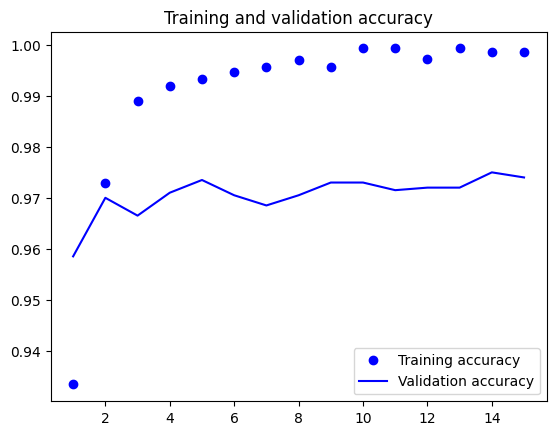

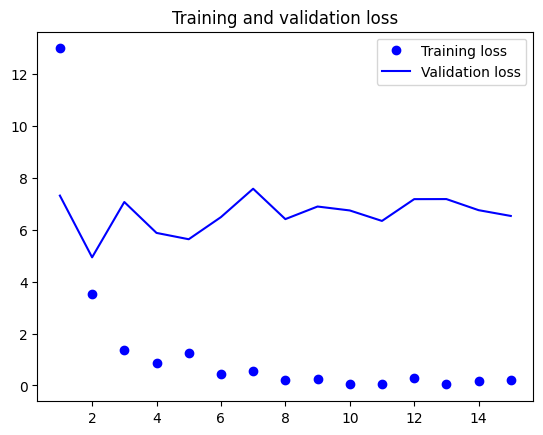

In [42]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [43]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False
     

conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))
     

conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))
     

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


## Feature extraction with the Data Augmentation.

In [44]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [45]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentationPT2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
94/94 [==============================] - 18s 167ms/step - loss: 13.5342 - accuracy: 0.9083 - val_loss: 2.9624 - val_accuracy: 0.9760
Epoch 2/5
94/94 [==============================] - 16s 167ms/step - loss: 6.4695 - accuracy: 0.9513 - val_loss: 2.8310 - val_accuracy: 0.9745
Epoch 3/5
94/94 [==============================] - 16s 163ms/step - loss: 4.5441 - accuracy: 0.9610 - val_loss: 3.7486 - val_accuracy: 0.9730
Epoch 4/5
94/94 [==============================] - 15s 161ms/step - loss: 4.0911 - accuracy: 0.9620 - val_loss: 4.4063 - val_accuracy: 0.9730
Epoch 5/5
94/94 [==============================] - 15s 160ms/step - loss: 3.2776 - accuracy: 0.9670 - val_loss: 3.8040 - val_accuracy: 0.9730


In [46]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentationPT2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 91ms/step - loss: 3.7229 - accuracy: 0.9740
Test accuracy: 0.974


Accuracy= 96.70%
val_Acc= 97.30%


## Summary:

The findings demonstrate that models that often underwent data augmentation during training were unable to outperform those that did not. By altering the size of the validation set or the training set, the model's accuracy is also improved. We can observe that the pre-trained model's accuracy and validation accuracy did not improve as a consequence of the data augmentation by comparing it to the pre-trained model without it. Pre-trained models frequently outperform models that are built from scratch overall, particularly when dealing with a lack of training data.